# Anomaly Event Recognition using ConvLSTM model

## **<font style="color:rgb(134,19,348)"> Outline </font>**

- **`Step 1:` Download the kaggle dataset to Colab**

- **`Step 2:` Preprocess the Dataset**

- **`Step 3:` Split the Data into Train and Test Set**

- **`Step 4:` Implement the ConvLSTM Approach**

    - **`Step 4.1:` Construct the Model**
    
    - **`Step 4.2:` Compile & Train the Model**
    
    - **`Step 4.3:` Plot Model’s Loss & Accuracy Curves**
    
- **`Step 5:` Test the model**

Alright, so without further ado, let's get started.

## **<font style="color:rgb(134,19,348)">Step 1: Download the kaggle dataset to Colab</font>**

We will be using the [Theft Detection Dataset](https://www.kaggle.com/datasets/thatbrownkid/thefttest), consisting of
realistic anomaly vedios. The "Anomaly-Videos-Part-2" folder under above DataSet contains:

*   **`100`** Burglary Vedios

*   **`50`** Explosion Vedios

*   **`50`** Fighting Vedios   


For downloading, we will setup the kaggle in Colab and then download the kaggle.json file.Then upload that json to colab and link the kaggle and Colab.After that download the zip file via API token and extract it in the colab.



In [ ]:
#setting up kaggle first
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#upload the downloaded kaggle.json file in order to link your kaggle account to colab.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thisaraweerakoon","key":"a0487c2b0fb05580151fb04085120fec"}'}

In [ ]:
#Make a directory named kaggle and copy the kaggle.json file there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#download the .zip file via API token of the dataset
!kaggle datasets download -d thatbrownkid/thefttest

100% 21.2G/21.2G [03:12<00:00, 105MB/s]
100% 21.2G/21.2G [03:12<00:00, 118MB/s]


In [ ]:
#unzip the file inside the Colab
from zipfile import ZipFile
file_name = 'thefttest.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

OSError: ignored

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

We will start by installing and importing the required libraries.

In [2]:
# Discard the output of this cell.
#%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-install-celnd0ek/pafy_2bf8ff60fec74fc690247e314a724692
  Running command git clone -q https://github.com/TahaAnwar/pafy.git /tmp/pip-install-celnd0ek/pafy_2bf8ff60fec74fc690247e314a724692
  Created wheel for pafy: filename=pafy-0.5.5-py2.py3-none-any.whl size=35706 sha256=f74f946047264334525c7a2a8a71c2125a71fed2151e2f0941dd860fa31104b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-36vunfmc/wheels/64/82/dd/3d7823b3bbbe1aca9b30f8cf0d6bb6c1b72ccd95e3360f8190
Successfully built pafy


In [3]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2867200/45929032 bytes (6.2%)6848512/45929032 bytes (14.9%)10747904/45929032 bytes (23.4%)14802944/45929032 bytes (32.2%)18833408/45929032 bytes (41.0%)22560768/45929032 bytes (49.1%)26509312/45929032 bytes (57.7%)30375936/45929032 bytes (66.1%)34365440/45929032 bytes (74.8%)38395904/45929032 bytes (83.6%)42295296/45929032 bytes (92.1%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**

Now, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height,and normalized the data to range `[0-1]` by dividing the pixel values with `255`.



In [4]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the Theft Detection dataset downloaded into the Colab 
DATASET_DIR = "/content/Anomaly-Videos-Part-2/Anomaly-Videos-Part-2"

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = ["Burglary", "Explosion", "Fighting"]

We create a function for extracting required frames from each vedio and returning us a list of resized , normalized frames

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**

Now we will create a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Now we will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Burglary
Extracting Data of Class: Explosion
Extracting Data of Class: Fighting


Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## **<font style="color:rgb(134,19,348)">Step 3: Split the Data into Train and Test Set</font>**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

## **<font style="color:rgb(134,19,348)">Step 4: Implement the ConvLSTM Approach</font>**



### **<font style="color:rgb(134,19,348)">Step 4.1: Construct the Model</font>**




In [5]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

Now we will utilize the function **`create_convlstm_model()`** created above, to construct the required `convlstm` model.

In [6]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**


Now we will use the **`plot_model()`** function, to check the structure of the constructed model, this is helpful while constructing a complex network and making that the network is created correctly.

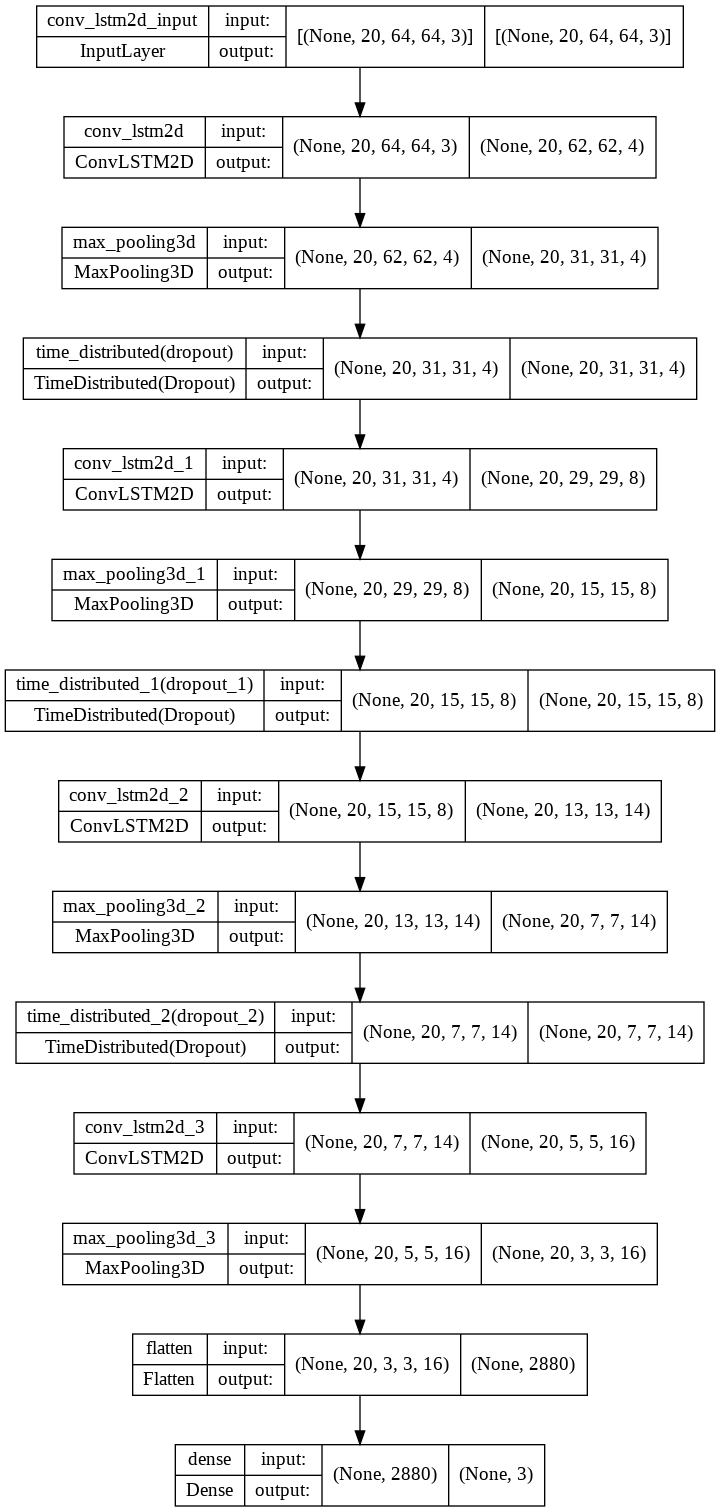

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 4.2: Compile & Train the Model</font>**


In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
30/30 [==============================] - 26s 287ms/step - loss: 1.0756 - accuracy: 0.5083 - val_loss: 1.0157 - val_accuracy: 0.6333
Epoch 2/50
30/30 [==============================] - 7s 248ms/step - loss: 1.0533 - accuracy: 0.5083 - val_loss: 1.0442 - val_accuracy: 0.6333
Epoch 3/50
30/30 [==============================] - 7s 251ms/step - loss: 1.0483 - accuracy: 0.5083 - val_loss: 0.9607 - val_accuracy: 0.6333
Epoch 4/50
30/30 [==============================] - 8s 251ms/step - loss: 1.0524 - accuracy: 0.5083 - val_loss: 0.9570 - val_accuracy: 0.6333
Epoch 5/50
30/30 [==============================] - 8s 251ms/step - loss: 1.0438 - accuracy: 0.4833 - val_loss: 0.9073 - val_accuracy: 0.6333
Epoch 6/50
30/30 [==============================] - 8s 273ms/step - loss: 1.0390 - accuracy: 0.5083 - val_loss: 0.9819 - val_accuracy: 0.6333
Epoch 7/50
30/30 [==============================] - 7s 248ms/step - loss: 1.0190 - accuracy: 0.5083 - val_loss: 0.9515 - val_accuracy: 0.6333
Epoch

#### **<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, we will evaluate the model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

2/2 [==============================] - 0s 165ms/step - loss: 1.1466 - accuracy: 0.4000


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

Now we will save the model to avoid training it from scratch every time we need the model.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 4.3: Plot Model’s Loss & Accuracy Curves</font>**


Now we will create a function **`plot_metric()`** to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

Now we will utilize the function **`plot_metric()`** created above, to visualize and understand the metrics.

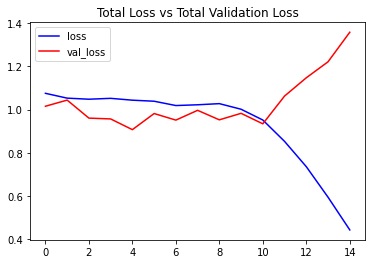

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

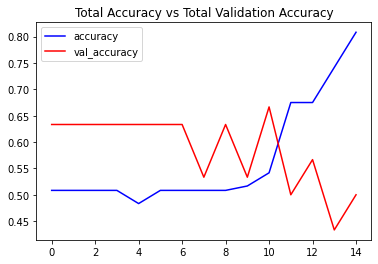

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

## **<font style="color:rgb(134,19,348)">Step 5: Test the Model</font>**

### **<font style="color:rgb(134,19,348)">Load the saved model for predictions</font>**

In [7]:
convlstm_model.load_weights("convlstm_model___Date_Time_2022_06_28__16_25_31___Loss_1.1465591192245483___Accuracy_0.4000000059604645.h5")

### **<font style="color:rgb(134,19,348)">Create a Function to Download YouTube Videos:</font>**

We will create a function **`download_youtube_videos()`** to download the YouTube videos first using **`pafy`** library. The library only requires a URL to a video to download it along with its associated metadata like the title of the video.

In [22]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''
 
     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)
 
     # Retrieve the title of the video.
     title = video.title
 
     # Get the best available quality object for the video.
     video_best = video.getbest()
 
     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'
 
     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)
 
     # Return the video title.
     return title

### **<font style="color:rgb(134,19,348)">Download a Test Video:</font>**

Now we will utilize the function **`download_youtube_videos()`** created above to download a youtube video on which the `ConvLSTM` model will be tested.

In [25]:
# Make the Output directory if it does not exist
test_videos_directory = 'testing'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://youtu.be/87-xHZagAEs', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

### **<font style="color:rgb(134,19,348)">Method 1:-Create a Function To Perform a Single Prediction on Videos</font>**


Now let's create a function that will perform a single prediction for the complete videos.This approach is really useful when you are working with videos containing only one activity   

In [11]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read() 

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    # Release the VideoCapture object. 
    video_reader.release()

### **<font style="color:rgb(134,19,348)">Perform Single Prediction on a Test Video</font>**

Now we will utilize the function **`predict_single_action()`** created above to perform a single prediction on a complete youtube test video that we will download using the function **`download_youtube_videos()`**, we had created above.

In [27]:
# Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

# Display the input video.
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

Action Predicted: Burglary
Confidence: 0.5737479329109192


100%|██████████| 3026/3026 [00:25<00:00, 117.64it/s]


ValueError: ignored

### **<font style="color:rgb(134,19,348)">Method 2:-Create a Function To Perform Action Recognition on Videos</font>**

Next, we will create a function **`predict_on_video()`** that will simply read a video frame by frame from the path passed in as an argument and will perform action recognition on video and save the results.

In [21]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

### **<font style="color:rgb(134,19,348)">Perform Action Recognition on the Test Video</font>**

Now we will utilize the function **`predict_on_video()`** created above to perform action recognition on the test video we had downloaded using the function **`download_youtube_videos()`** and display the output video with the predicted action overlayed on it.

In [26]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|██████████| 3025/3025 [00:20<00:00, 144.95it/s]


ValueError: ignored